In [1]:
#Moscot library tutorial

In [1]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mtp
from moscot.problems.time import TemporalProblem
from tqdm.std import TqdmWarning

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)

In [2]:
adata = mt.datasets.hspc()
adata

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [4]:
adata.obs.day

cell_id
4c45fb900fbb    2
c462df3e03b5    2
27b9aa554758    2
9a0cbad09594    2
98b88fc30c58    2
               ..
946cf349f84e    7
da6baa1b0624    7
ba7d40e15f3d    7
69451694ec4c    7
193992d571a5    7
Name: day, Length: 4000, dtype: category
Categories (4, int64): [2, 3, 4, 7]

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


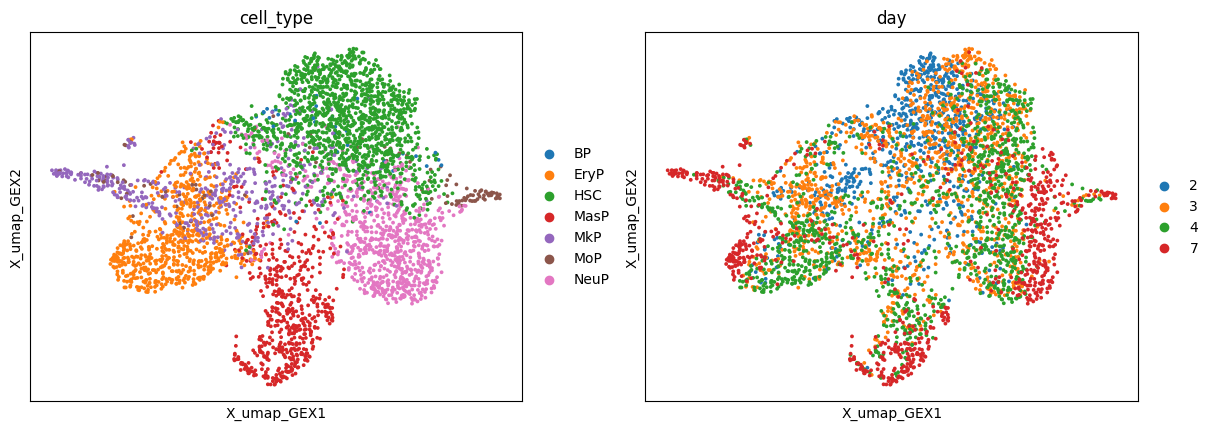

In [4]:
sc.pl.embedding(adata, basis="X_umap_GEX", color=["cell_type", "day"])

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


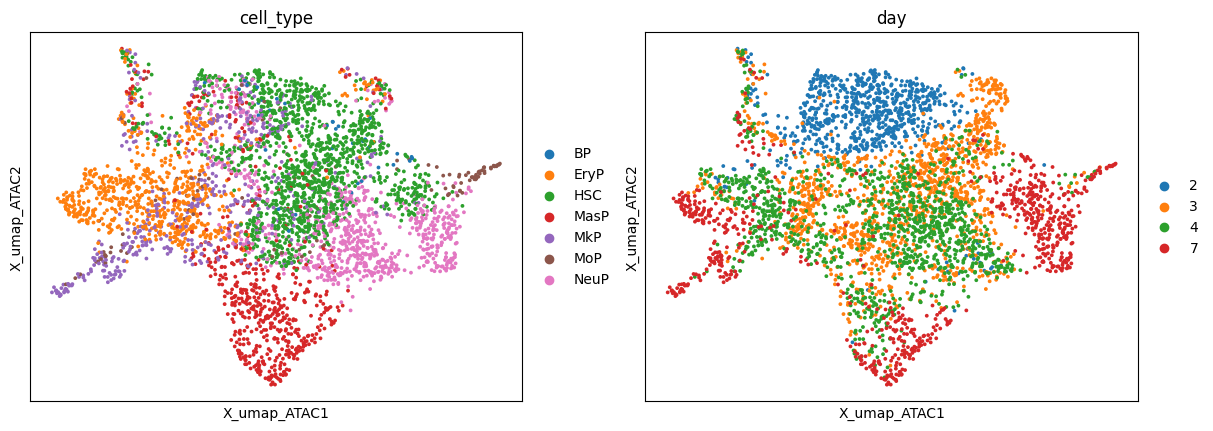

In [5]:
sc.pl.embedding(adata, basis="X_umap_ATAC", color=["cell_type", "day"])

In [5]:
np.var(adata.obsm["X_lsi"]), np.var(adata.obsm["X_pca"])

(1.0000002, 39.049347)

In [6]:
adata.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata.obsm["X_pca"])
adata.obsm["X_shared"] = sc.pp.pca(
    np.concatenate((adata.obsm["X_pca_scaled"], adata.obsm["X_lsi"]), axis=1),
    n_comps=30,
)

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [7]:
tp = TemporalProblem(adata)

In [8]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

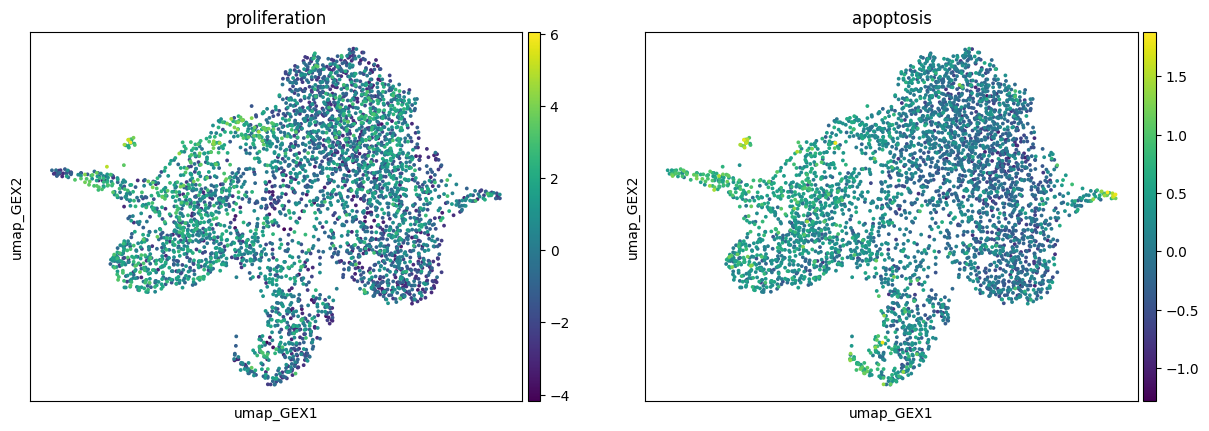

In [11]:
sc.pl.embedding(adata, basis="umap_GEX", color=["proliferation", "apoptosis"])

In [9]:
tp = tp.prepare(time_key="day", joint_attr="X_shared")

INFO     Ordering Index(['4c45fb900fbb', 'c462df3e03b5', '27b9aa554758', '9a0cbad09594',                           
                '98b88fc30c58', '5008d863224a', '904d6bcfd520', '5287a74337a0',                                    
                '862d6d6e4e49', '288e38fb37aa',                                                                    
                ...                                                                                                
                '038518e366a9', '809ba84a9cbb', '4264c55de7d0', 'a7097007fbea',                                    
                '1381ec6cb466', '946cf349f84e', 'da6baa1b0624', 'ba7d40e15f3d',                                    
                '69451694ec4c', '193992d571a5'],                                                                   
               dtype='object', name='cell_id', length=4000) in ascending order.                                    


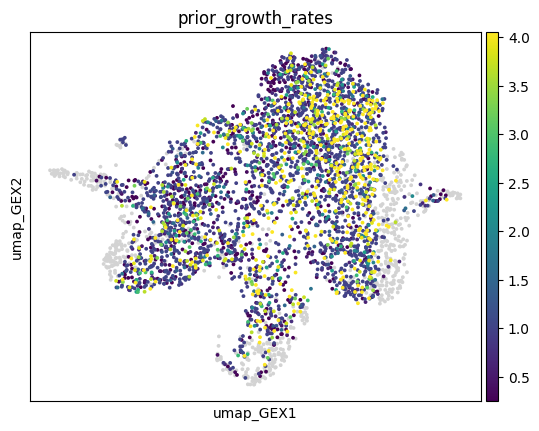

In [13]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates")

In [14]:
tp = tp.solve(epsilon=1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


In [15]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:524: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_1, df_2], verify_integrity=True)


In [20]:
adata.obs

,day,donor,cell_type,technology,n_genes,proliferation,apoptosis,prior_growth_rates,posterior_growth_rates
cell_id,,,,,,,,,
4c45fb900fbb,2,31800,HSC,multiome,3633,0.718326,0.307205,0.989633,0.243688
c462df3e03b5,2,31800,EryP,multiome,5162,2.380084,0.642209,1.000027,1.243304
27b9aa554758,2,31800,MasP,multiome,3600,-0.643920,-0.097889,0.975164,1.628448
9a0cbad09594,2,31800,MkP,multiome,5437,-0.501629,0.016707,0.803201,1.387531
98b88fc30c58,2,31800,MkP,multiome,4300,0.179323,-0.108195,1.625443,1.204373
...,...,...,...,...,...,...,...,...,...
946cf349f84e,7,31800,NeuP,multiome,3965,0.025608,-0.364370,NaN,NaN
da6baa1b0624,7,31800,MoP,multiome,3791,3.347055,0.676220,NaN,NaN
ba7d40e15f3d,7,31800,MoP,multiome,1894,-2.224994,1.881702,NaN,NaN


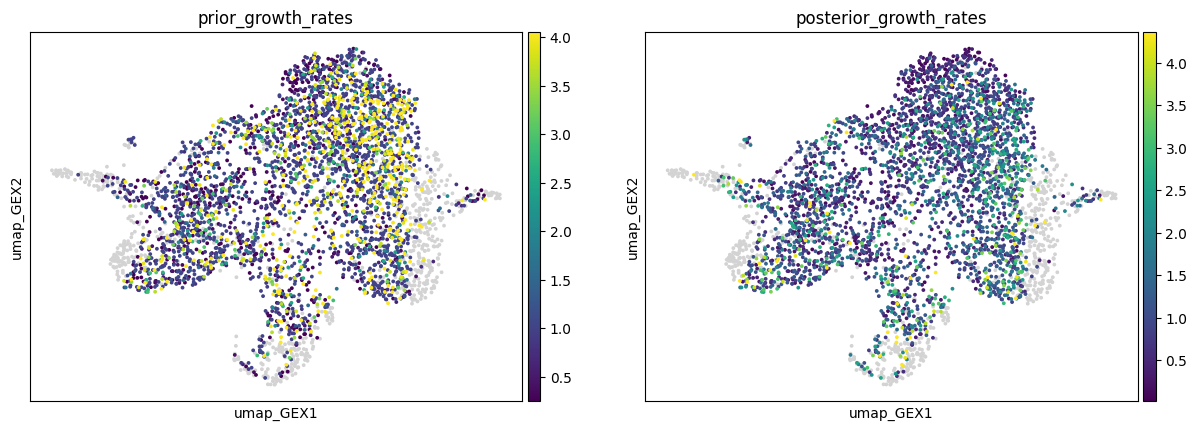

In [21]:
sc.pl.embedding(
    adata,
    basis="umap_GEX",
    color=["prior_growth_rates", "posterior_growth_rates"],
    vmax="p99",
)

In [22]:
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:549: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_1, df_2], verify_integrity=True)
/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot/problems/time/_mixins.py:574: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_1, df_2], verify_integrity=True)


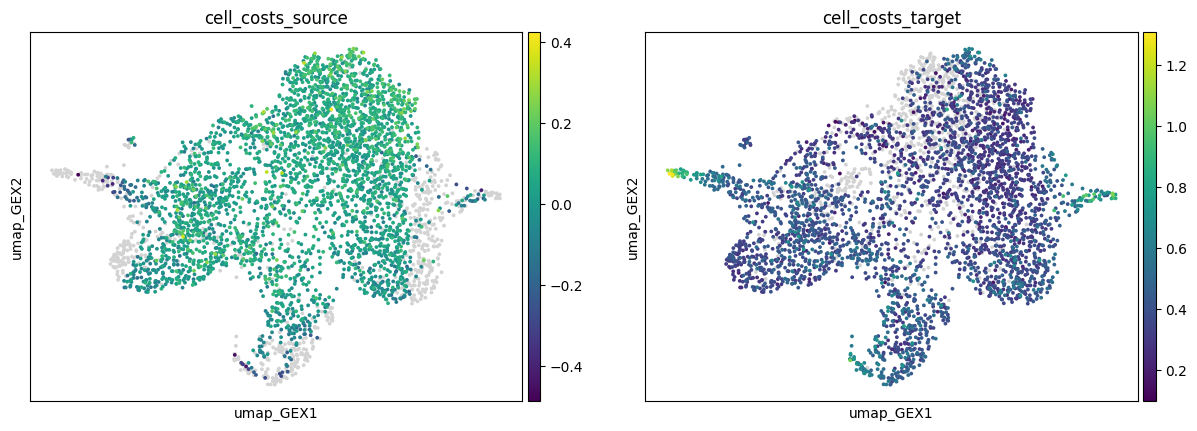

In [23]:
sc.pl.embedding(
    adata, basis="umap_GEX", color=["cell_costs_source", "cell_costs_target"]
)

/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot/base/problems/_mixins.py:401: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_dist = df[df[annotation_key].isin(annotations_2)].groupby(annotation_key).sum(numeric_only=True)
/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot/base/problems/_mixins.py:401: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_dist = df[df[annotation_key].isin(annotations_2)].groupby(annotation_key).sum(numeric_only=True)
/fast/AG_Haghverdi/Shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/moscot

KeyError: "No data found in `adata.uns['moscot_results']['cell_transition']['cell_transition']`."

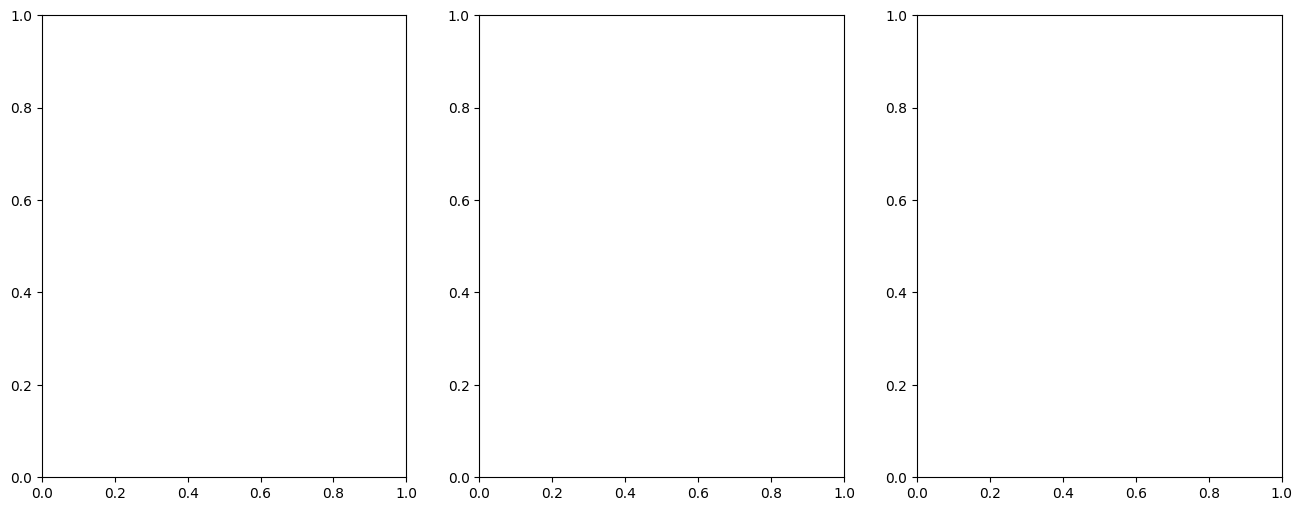

In [30]:
ct_desc = tp.cell_transition(
    2, 3, "cell_type", "cell_type", forward=False, key_added="transitions_2_3"
)
ct_desc = tp.cell_transition(
    3, 4, "cell_type", "cell_type", forward=False, key_added="transitions_3_4"
)
ct_desc = tp.cell_transition(
    4, 7, "cell_type", "cell_type", forward=False, key_added="transitions_4_7"
)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))

axes[0] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    uns_key="transitions_2_3",
)

axes[1] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    uns_key="transitions_3_4",
)

axes[2] = mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[2],
    uns_key="transitions_4_7",
)

fig.subplots_adjust(wspace=0.4)

In [34]:
from moscot.plotting import _utils
adata.uns['moscot_results']['cell_transition']

{'transitions_2_3': {'source': 2,
  'target': 3,
  'source_groups': 'cell_type',
  'target_groups': 'cell_type',
  'transition_matrix':             BP      EryP       HSC      MasP           MkP           MoP  \
  BP    0.426347  0.003844  0.044483  0.007966  2.931274e-02  1.978342e-10   
  EryP  0.000000  0.599304  0.003085  0.075328  2.338554e-01  2.052733e-01   
  HSC   0.385406  0.117460  0.792177  0.150987  1.993657e-01  2.040312e-01   
  MasP  0.000000  0.069587  0.013107  0.513325  7.838396e-02  3.568814e-02   
  MkP   0.000000  0.178830  0.075849  0.147181  3.824221e-01  2.125818e-01   
  MoP   0.188247  0.000000  0.010381  0.000026  1.235261e-13  6.937400e-02   
  NeuP  0.000000  0.030975  0.060918  0.105186  7.666004e-02  2.730517e-01   
  
            NeuP  
  BP    0.000449  
  EryP  0.029248  
  HSC   0.230283  
  MasP  0.041322  
  MkP   0.052879  
  MoP   0.003746  
  NeuP  0.642073  },
 'transitions_3_4': {'source': 3,
  'target': 4,
  'source_groups': 'cell_type',
  't

In [41]:
adata1, adata2 = _input_to_adatas(tp)

In [43]:
adata2

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes', 'proliferation', 'apoptosis', 'prior_growth_rates', 'posterior_growth_rates', 'cell_costs_source', 'cell_costs_target'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap', 'day_colors', 'moscot_results'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf', 'X_pca_scaled', 'X_shared'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [48]:
data = get_plotting_vars(adata1, func_key='cell_transition',key='transitions_2_3')

In [51]:
fig = _heatmap(
    row_adata=adata1,
    col_adata=adata2,
    transition_matrix=data["transition_matrix"],
    row_annotation=data["source_groups"]
    if isinstance(data["source_groups"], str)
    else next(iter(data["source_groups"])),
    col_annotation=data["target_groups"]
    if isinstance(data["target_groups"], str)
    else next(iter(data["target_groups"])),
    cont_cmap="viridis",
    annotate_values=annotate,
    fontsize=fontsize,
    figsize=figsize,
    dpi=dpi,
    ax=ax,
    save=save,
    cbar_kwargs=cbar_kwargs,
    **kwargs,
)
return fig if return_fig else None

NameError: name 'annotate' is not defined

In [40]:
import collections
import contextlib
import copy
import pathlib
import types
from typing import (
    TYPE_CHECKING,
    Any,
    Dict,
    List,
    Mapping,
    Optional,
    Sequence,
    Set,
    Tuple,
    Union,
)

import numpy as np
import pandas as pd
from pandas.api.types import is_categorical_dtype
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scanpy as sc
from anndata import AnnData
from scanpy.plotting._utils import (
    add_colors_for_categorical_sample_annotation as add_color_palette,
)

if TYPE_CHECKING:
    from moscot.base.problems import CompoundProblem


def set_palette(
    adata: AnnData,
    key: str,
    cont_cmap: Union[str, mpl.colors.Colormap] = "viridis",
    force_update_colors: bool = True,
    **_: Any,
) -> None:
    """Set palette."""
    if key not in adata.obs:
        raise KeyError(f"Unable to find data in `adata.obs[{key!r}]`.")
    uns_key = f"{key}_colors"
    if uns_key not in adata.uns:
        add_color_palette(adata, key=key, palette=cont_cmap, force_update_colors=force_update_colors)


# adapted from https://github.com/anazalea/pySankey/blob/master/pysankey/sankey.py
def _sankey(
    adata: AnnData,
    key: str,
    transition_matrices: List[pd.DataFrame],
    captions: Optional[List[str]] = None,
    colorDict: Optional[Union[Dict[Any, str], mpl.colors.ListedColormap]] = None,
    title: Optional[str] = None,
    figsize: Optional[Tuple[float, float]] = None,
    dpi: Optional[int] = None,
    ax: Optional[mpl.axes.Axes] = None,
    cont_cmap: Union[str, mpl.colors.Colormap] = "viridis",
    fontsize: float = 12.0,
    horizontal_space: float = 1.5,
    force_update_colors: bool = False,
    alpha: float = 1.0,
    interpolate_color: bool = False,
    side_bar_width: float = 0.02,  # width of the bars on left and right of the sankey strips
    **kwargs: Any,
) -> mpl.figure.Figure:
    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True, dpi=dpi, figsize=figsize)
    else:
        fig = ax.figure
    if captions is not None and len(captions) != len(transition_matrices):
        raise ValueError(f"Expected captions to be of length `{len(transition_matrices)}`, found `{len(captions)}`.")
    if colorDict is None:
        # TODO: adapt for unique categories
        set_palette(adata=adata, key=key, cont_cmap=cont_cmap, force_update_colors=force_update_colors)

        colorDict = {cat: adata.uns[f"{key}_colors"][i] for i, cat in enumerate(adata.obs[key].cat.categories)}
    else:
        missing = sorted(label for label in adata.obs[key].cat.categories if label not in colorDict)
        if missing:
            raise ValueError(f"The following labels have missing colors: `{missing}`.")
    left_pos = [0]
    for ind, dataFrame in enumerate(transition_matrices):
        dataFrame /= dataFrame.values.sum()
        leftLabels = list(dataFrame.index)
        rightLabels = list(dataFrame.columns)

        # Determine positions of left label patches and total widths
        leftWidths: Dict[Any, Dict[Any, float]] = collections.defaultdict()
        for i, leftLabel in enumerate(leftLabels):
            myD = {}
            myD["left"] = dataFrame.loc[leftLabel, :].sum()
            if i == 0:
                myD["bottom"] = 0
                myD["top"] = myD["left"]
            else:
                myD["bottom"] = leftWidths[leftLabels[i - 1]]["top"]
                myD["top"] = myD["bottom"] + myD["left"]
                topEdge = myD["top"]
            leftWidths[leftLabel] = myD

        # Determine positions of right label patches and total widths
        rightWidths: Dict[Any, Dict[Any, float]] = collections.defaultdict()
        for i, rightLabel in enumerate(rightLabels):
            myD = {}
            myD["right"] = dataFrame.loc[:, rightLabel].sum()
            if i == 0:
                myD["bottom"] = 0
                myD["top"] = myD["right"]
            else:
                myD["bottom"] = rightWidths[rightLabels[i - 1]]["top"]
                myD["top"] = myD["bottom"] + myD["right"]
                topEdge = myD["top"]
            rightWidths[rightLabel] = myD

        # Total vertical extent of diagram
        xMax = topEdge
        # Draw vertical bars on left and right of each label"s section & print label
        for leftLabel in leftLabels:
            if ind == 0:
                ax.fill_between(
                    [-side_bar_width * xMax, 0],
                    2 * [leftWidths[leftLabel]["bottom"]],
                    2 * [leftWidths[leftLabel]["bottom"] + leftWidths[leftLabel]["left"]],
                    color=colorDict[leftLabel],
                    alpha=1.0,
                    **kwargs,
                )
                ax.text(
                    -0.05 * xMax,
                    leftWidths[leftLabel]["bottom"] + 0.5 * leftWidths[leftLabel]["left"],
                    leftLabel,
                    {"ha": "right", "va": "center"},
                    fontsize=fontsize,
                )
        for rightLabel in rightLabels:
            ax.fill_between(
                [xMax + left_pos[ind], (1 + side_bar_width) * xMax + left_pos[ind]],
                2 * [rightWidths[rightLabel]["bottom"]],
                2 * [rightWidths[rightLabel]["bottom"] + rightWidths[rightLabel]["right"]],
                color=colorDict[rightLabel],
                alpha=1.0,
                **kwargs,
            )
            ax.text(
                1.05 * xMax + left_pos[ind],
                rightWidths[rightLabel]["bottom"] + 0.5 * rightWidths[rightLabel]["right"],
                rightLabel,
                {"ha": "left", "va": "center"},
                fontsize=fontsize,
            )

        if captions is not None:
            ax.text(left_pos[ind] + 0.3 * xMax, -0.1, captions[ind])

        left_pos += [left_pos[-1] + horizontal_space * xMax]

        # Plot strips
        for leftLabel in leftLabels:
            for rightLabel in rightLabels:
                if dataFrame.loc[leftLabel, rightLabel] > 0:
                    # Create array of y values for each strip, half at left value,
                    # half at right, convolve
                    ys_d = np.array(50 * [leftWidths[leftLabel]["bottom"]] + 50 * [rightWidths[rightLabel]["bottom"]])
                    ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode="valid")
                    ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode="valid")
                    ys_u = np.array(
                        50 * [leftWidths[leftLabel]["bottom"] + dataFrame.loc[leftLabel, rightLabel]]
                        + 50 * [rightWidths[rightLabel]["bottom"] + dataFrame.loc[leftLabel, rightLabel]]
                    )
                    ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode="valid")
                    ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode="valid")

                    # Update bottom edges at each label so next strip starts at the right place
                    leftWidths[leftLabel]["bottom"] += dataFrame.loc[leftLabel, rightLabel]
                    rightWidths[rightLabel]["bottom"] += dataFrame.loc[leftLabel, rightLabel]

                    arr = np.linspace(0 + left_pos[ind], xMax + left_pos[ind], len(ys_d))
                    if interpolate_color:
                        color = _color_transition(
                            colorDict[leftLabel], colorDict[rightLabel], num=len(arr), alpha=alpha
                        )
                        for l in range(len(ys_d)):  # necessary to get smooth lines
                            ax.fill_between(
                                arr[l:], ys_d[l:], ys_u[l:], color=color[l], ec=color[l], alpha=alpha, **kwargs
                            )
                    else:
                        ax.fill_between(arr, ys_d, ys_u, alpha=alpha, color=colorDict[leftLabel], **kwargs)

        ax.axis("off")
        ax.set_title(title)
    return fig


def _heatmap(
    row_adata: AnnData,
    col_adata: AnnData,
    transition_matrix: pd.DataFrame,
    row_annotation: str,
    col_annotation: str,
    row_annotation_label: Optional[str] = None,
    col_annotation_label: Optional[str] = None,
    cont_cmap: Union[str, mpl.colors.Colormap] = "viridis",
    annotate_values: Optional[str] = "{x:.2f}",
    fontsize: float = 7.0,
    figsize: Optional[Tuple[float, float]] = None,
    dpi: Optional[int] = None,
    save: Optional[Union[str, pathlib.Path]] = None,
    cbar_kwargs: Mapping[str, Any] = types.MappingProxyType({}),
    ax: Optional[mpl.axes.Axes] = None,
    **kwargs: Any,
) -> plt.Figure:
    cbar_kwargs = dict(cbar_kwargs)

    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True, dpi=dpi, figsize=figsize)
    else:
        fig = ax.figure
    if row_annotation != "cell":
        set_palette(adata=row_adata, key=row_annotation, cont_cmap=cont_cmap)
    if col_annotation != "cell":
        set_palette(adata=col_adata, key=col_annotation, cont_cmap=cont_cmap)

    row_cmap, col_cmap, row_norm, col_norm = _get_cmap_norm(
        row_adata, col_adata, transition_matrix, row_annotation, col_annotation
    )

    row_sm = mpl.cm.ScalarMappable(cmap=row_cmap, norm=row_norm)
    col_sm = mpl.cm.ScalarMappable(cmap=col_cmap, norm=col_norm)

    norm = mpl.colors.Normalize(
        vmin=kwargs.pop("vmin", np.nanmin(transition_matrix)), vmax=kwargs.pop("vmax", np.nanmax(transition_matrix))
    )
    cont_cmap = copy.copy(plt.get_cmap(cont_cmap))
    cont_cmap.set_bad(color="grey")

    im = ax.imshow(transition_matrix, cmap=cont_cmap, norm=norm)
    ax.grid(False)
    ax.tick_params(top=False, bottom=False, labeltop=False, labelbottom=False)
    ax.set_xticks([])
    ax.set_yticks([])

    if annotate_values is not None:
        _annotate_heatmap(transition_matrix, im, valfmt=annotate_values, cmap=cont_cmap, fontsize=fontsize, **kwargs)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    _ = fig.colorbar(
        im,
        cax=cax,
        ticks=np.linspace(norm.vmin, norm.vmax, 10),
        orientation="vertical",
        format="%0.2f",
        **cbar_kwargs,
    )

    if col_annotation != "cell":
        col_cats = divider.append_axes("top", size="2%", pad=0)
        c = fig.colorbar(col_sm, cax=col_cats, orientation="horizontal", ticklocation="top")

        c.set_ticks(np.arange(transition_matrix.shape[1]) + 0.5)
        c.ax.set_xticklabels(transition_matrix.columns, rotation=90)
        c.set_label(col_annotation if col_annotation_label is None else col_annotation_label)
    if row_annotation != "cell":
        row_cats = divider.append_axes("left", size="2%", pad=0)
        c = fig.colorbar(row_sm, cax=row_cats, orientation="vertical", ticklocation="left")

        c.set_ticks(np.arange(transition_matrix.shape[0]) + 0.5)
        c.ax.set_yticklabels(transition_matrix.index[::-1])
        c.set_label(row_annotation if row_annotation_label is None else row_annotation_label)

    if save:
        fig.savefig(save, bbox_inches="tight")
    return fig


def _get_black_or_white(value: float, cmap: mpl.colors.Colormap) -> str:
    if not (0.0 <= value <= 1.0):
        raise ValueError(f"Expected value to be in interval `[0, 1]`, found `{value}`.")

    r, g, b, *_ = (int(c * 255) for c in cmap(value))
    return _contrasting_color(r, g, b)


def _annotate_heatmap(
    transition_matrix: pd.DataFrame,
    im: mpl.image.AxesImage,
    valfmt: str = "{x:.2f}",
    cmap: Union[mpl.colors.Colormap, str] = "viridis",
    fontsize: float = 5,
    **kwargs: Any,
) -> None:
    # modified from matplotlib's site
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)

    kw = {"ha": "center", "va": "center"}
    kw.update(**kwargs)

    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)
    if TYPE_CHECKING:
        assert callable(valfmt)

    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            val = im.norm(transition_matrix.iloc[i, j])
            if np.isnan(val):
                continue
            kw.update(color=_get_black_or_white(val, cmap))
            im.axes.text(j, i, valfmt(transition_matrix.iloc[i, j], None), fontsize=fontsize, **kw)


def _get_cmap_norm(
    row_adata: AnnData,
    col_adata: AnnData,
    transition_matrix: pd.DataFrame,
    row_annotation: str,
    col_annotation: str,
) -> Tuple[mpl.colors.ListedColormap, mpl.colors.ListedColormap, mpl.colors.BoundaryNorm, mpl.colors.BoundaryNorm]:
    if row_annotation != "cell":
        row_color_dict = {
            row_adata.obs[row_annotation].cat.categories[i]: col
            for i, col in enumerate(row_adata.uns[f"{row_annotation}_colors"])
        }
        row_colors = [row_color_dict[cat] for cat in transition_matrix.index][::-1]
    else:
        row_colors = [0, 0, 0]

    if col_annotation != "cell":
        col_color_dict = {
            col_adata.obs[col_annotation].cat.categories[i]: col
            for i, col in enumerate(col_adata.uns[f"{col_annotation}_colors"])
        }
        col_colors = [col_color_dict[cat] for cat in transition_matrix.columns]
    else:
        col_colors = [0, 0, 0]

    row_cmap = mpl.colors.ListedColormap(row_colors)
    col_cmap = mpl.colors.ListedColormap(col_colors)
    row_norm = mpl.colors.BoundaryNorm(np.arange(transition_matrix.shape[0] + 1), transition_matrix.shape[0])
    col_norm = mpl.colors.BoundaryNorm(np.arange(transition_matrix.shape[1] + 1), transition_matrix.shape[1])

    return row_cmap, col_cmap, row_norm, col_norm


def _contrasting_color(r: int, g: int, b: int) -> str:
    for val in [r, g, b]:
        assert 0 <= val <= 255, f"Color value `{val}` is not in `[0, 255]`."

    return "#000000" if r * 0.299 + g * 0.587 + b * 0.114 > 186 else "#ffffff"


def _input_to_adatas(
    inp: Union[AnnData, Tuple[AnnData, AnnData], "CompoundProblem"]  # type: ignore[type-arg]
) -> Tuple[AnnData, AnnData]:
    from moscot.base.problems import CompoundProblem

    if isinstance(inp, CompoundProblem):
        return inp.adata, inp.adata
    if isinstance(inp, AnnData):
        return inp, inp
    if isinstance(inp, tuple):
        if not isinstance(inp[0], AnnData):
            raise TypeError(f"Expected object to be of type `AnnData`, found `{type(inp[0])}`.")
        if not isinstance(inp[1], AnnData):
            raise TypeError(f"Expected object to be of type `AnnData`, found `{type(inp[1])}`.")
        return inp
    raise ValueError(f"Unable to interpret input of type `{type(inp)}`.")


def _plot_temporal(
    adata: AnnData,
    temporal_key: str,
    key_stored: str,
    source: float,
    target: float,
    categories: Optional[Union[str, List[str]]] = None,
    *,
    push: bool,
    time_points: Optional[Sequence[float]] = None,
    basis: str = "umap",
    constant_fill_value: float = np.nan,
    scale: bool = True,
    cont_cmap: Optional[Union[str, mpl.colors.Colormap]] = "viridis",
    title: Optional[Union[str, List[str]]] = None,
    suptitle: Optional[str] = None,
    figsize: Optional[Tuple[float, float]] = None,
    dpi: Optional[int] = None,
    dot_scale_factor: float = 2.0,
    na_color: str = "#e8ebe9",
    save: Optional[Union[str, pathlib.Path]] = None,
    ax: Optional[mpl.axes.Axes] = None,
    suptitle_fontsize: Optional[float] = None,
    **kwargs: Any,
) -> Optional[plt.Figure]:
    if time_points is not None:
        time_points = sorted(time_points)
    if cont_cmap is None or isinstance(cont_cmap, str):
        cont_cmap = plt.get_cmap(cont_cmap)

    if ax is None:
        fig, ax = plt.subplots(
            1, 1 if time_points is None else len(time_points), figsize=figsize, dpi=dpi, constrained_layout=True
        )
    else:
        fig = None
    axs = np.ravel([ax])  # make into iterable

    if not push and time_points is not None:
        time_points = time_points[::-1]

    if isinstance(title, list):
        if TYPE_CHECKING:
            assert isinstance(time_points, list)
        if len(title) != len(time_points):
            raise ValueError("If `title` is a list, its length must be equal to the length of `time_points`.")
        titles = title
    else:
        name = "descendants" if push else "ancestors"
        if time_points is not None:
            titles = [f"{categories if categories is not None else 'Cells'} at time {source if push else target}"]
            titles.extend([f"{name} at time {time_points[i]}" for i in range(1, len(time_points))])
        else:
            titles = [
                f"{categories if categories is not None else 'Cells'} at time {source if push else target} and {name}"
            ]
    for i, ax in enumerate(axs):
        # we need to create adata_view because otherwise the view of the adata is copied in the next step i+1
        with RandomKeys(adata, n=2, where="obs") as keys:
            if time_points is None:
                if scale:
                    adata.obs[keys[0]] = (
                        MinMaxScaler().fit_transform(adata.obs[key_stored].values.reshape(-1, 1)).squeeze()
                    )
                else:
                    adata.obs[keys[0]] = adata.obs[key_stored]
                size = None
                adata_view = adata
            else:
                tmp = np.full(len(adata), constant_fill_value)
                mask = adata.obs[temporal_key] == time_points[i]

                tmp[mask] = adata[mask].obs[key_stored]
                if scale:
                    tmp[mask] = (
                        MinMaxScaler().fit_transform(adata[mask].obs[key_stored].values.reshape(-1, 1)).squeeze()
                    )
                else:
                    tmp = mask * adata.obs[key_stored]

                size = (mask * 120000 * dot_scale_factor + (1 - mask) * 120000) / adata.n_obs  # 120,000 from scanpy

                _ = kwargs.pop("color_map", None)
                _ = kwargs.pop("palette", None)
                if (time_points[i] == source and push) or (time_points[i] == target and not push):
                    st = f"not in {time_points[i]}"
                    vmin, vmax = np.nanmin(tmp[mask]), np.nanmax(tmp[mask])
                    column = pd.Series(tmp).fillna(st).astype("category")
                    # TODO(michalk8): check
                    if len(np.unique(column[mask.values].values)) > 2:
                        raise ValueError(f"Not exactly two categories, found `{column.cat.categories}`.")
                    adata.obs[keys[0]] = column.values
                    adata.obs[keys[0]] = adata.obs[keys[0]].astype("category")
                    adata.obs[keys[1]] = list(range(adata.n_obs))

                    set_palette(
                        adata, keys[0], cont_cmap={vmax: cont_cmap.reversed()(0), vmin: cont_cmap(0), st: na_color}
                    )

                    cells_with_vmax = adata[adata.obs[keys[0]] == vmax].obs[keys[1]].values
                    cells_with_vmin = adata[adata.obs[keys[0]] == vmin].obs[keys[1]].values
                    cells_with_st = adata[adata.obs[keys[0]] == st].obs[keys[1]].values
                    indices = list(cells_with_st) + list(cells_with_vmin) + list(cells_with_vmax)
                    adata_view = adata[indices, :]
                    size = size[indices]
                else:
                    kwargs["color_map"] = cont_cmap
                    kwargs["na_color"] = na_color
                    adata.obs[keys[0]] = tmp
                    adata_view = adata

            sc.pl.embedding(
                adata=adata_view,
                basis=basis,
                color=keys[0],
                title=titles[i],
                size=size,
                ax=ax,
                show=False,
                return_fig=False,
                **kwargs,
            )
    if suptitle is not None:
        if fig is None:
            raise Warning("Cannot set `suptitle` of figure when `ax` is not `None`.")
        fig.suptitle(suptitle, fontsize=suptitle_fontsize)
    if save:
        if fig is None:
            raise ValueError("Figure cannot be saved when `ax` is not `None`.")
        fig.savefig(save, bbox_inches="tight")
    return fig


def _color_transition(c1: str, c2: str, num: int, alpha: float) -> List[str]:
    if not mpl.colors.is_color_like(c1):
        raise ValueError(f"{c1} cannot be interpreted as an RGB color.")
    if not mpl.colors.is_color_like(c2):
        raise ValueError(f"{c2} cannot be interpreted as an RGB color.")
    c1_rgb = np.asarray(mpl.colors.to_rgb(c1))
    c2_rgb = np.asarray(mpl.colors.to_rgb(c2))
    return [mpl.colors.to_rgb((1 - n / num) * c1_rgb + n / num * c2_rgb) + (alpha,) for n in range(num)]


def _create_col_colors(adata: AnnData, obs_col: str, subset: Union[str, List[str]]) -> Optional[mpl.colors.Colormap]:
    if isinstance(subset, list):
        subset = subset[0]
    if not is_categorical_dtype(adata.obs[obs_col]):
        raise TypeError(f"`adata.obs[{obs_col!r}] must be of categorical type.")

    for i, cat in enumerate(adata.obs[obs_col].cat.categories):
        if cat == subset:
            color = adata.uns[f"{obs_col}_colors"][i]
            break
    else:
        raise ValueError(f"Cannot find color for {subset} in `adata.obs[{obs_col!r}]`.")

    h, _, v = mpl.colors.rgb_to_hsv(mpl.colors.to_rgb(color))
    end_color = mpl.colors.hsv_to_rgb([h, 1, v])

    return mpl.colors.LinearSegmentedColormap.from_list("category_cmap", ["darkgrey", end_color])


def set_plotting_vars(
    adata: AnnData,
    func_key: str,
    *,
    key: str,
    value: Any,
    override: bool = True,
) -> None:
    uns_key = "moscot_results"
    adata.uns.setdefault(uns_key, {}).setdefault(func_key, {})
    if not override and key in adata.uns[uns_key][func_key]:
        raise KeyError(
            f"Data in `adata.uns[{uns_key!r}][{func_key!r}][{key!r}]` " f"already exists, use `override=True`."
        )
    adata.uns[uns_key][func_key][key] = value


def get_plotting_vars(adata: AnnData, func_key: str, *, key: str) -> Any:
    uns_key = "moscot_results"
    try:
        return adata.uns[uns_key][func_key][key]
    except KeyError:
        raise KeyError(f"No data found in `adata.uns[{uns_key!r}][{func_key!r}][{key!r}]`.") from None


class RandomKeys:
    """
    Create random keys inside an :class:`~anndata.AnnData` object.

    Parameters
    ----------
    adata
        Annotated data object.
    n
        Number of keys, If `None`, create just 1 keys.
    where
        Attribute of ``adata``. If `'obs'`, also clean up `'{key}_colors'` for each generated key.

    """

    def __init__(self, adata: AnnData, n: Optional[int] = None, where: str = "obs"):
        self._adata = adata
        self._where = where
        self._n = n or 1
        self._keys: List[str] = []

    def _generate_random_keys(self):
        def generator() -> str:
            return f"RNG_COL_{np.random.RandomState().randint(2 ** 16)}"

        where = getattr(self._adata, self._where)
        names: List[str] = []
        seen: Set[str] = set(where.keys())

        while len(names) != self._n:
            name = generator()
            if name not in seen:
                seen.add(name)
                names.append(name)

        return names

    def __enter__(self):
        self._keys = self._generate_random_keys()
        return self._keys

    def __exit__(self, exc_type, exc_val, exc_tb):
        with contextlib.suppress(KeyError):
            for key in self._keys:
                df = getattr(self._adata, self._where)
                df.drop(key, axis="columns", inplace=True)
                if self._where == "obs":
                    del self._adata.uns[f"{key}_colors"]